✅ Loaded data: (7160831, 46)
Train: (5728664, 45) Test: (1432167, 45)
 Client 1: X=(737053, 45), counts=[    16   2651  74018 135114 193067 264953     91  14221  18571   7188
   1227   1487   1197   4317    939   1079    101  16814      2]
 Client 2: X=(516008, 45), counts=[   374  28041 146070    293      2  14973  30129 127970 127310  29475
   2924   2241   4638    369      1   1026      3    127     42]
 Client 3: X=(307181, 45), counts=[ 1936 16378 59305  1900  7310 41398 73739 38561   914 42590  4819  2216
   238 12196    32   777   214  2608    50]
 Client 4: X=(1031111, 45), counts=[  1377  83032  30554 404464  71555   3098 154206   2094  16041 212440
  13742    609    127   8058    778    177     15  28337    407]
 Client 5: X=(805704, 45), counts=[  6482    158  61907    288 103120 519066      1  49175   2055    625
  46845   4593     18   5748    422    101      0   5088     12]
 Client 6: X=(191374, 45), counts=[  766  2096 18237 80919 15467 23375 17173    50   247 11238    

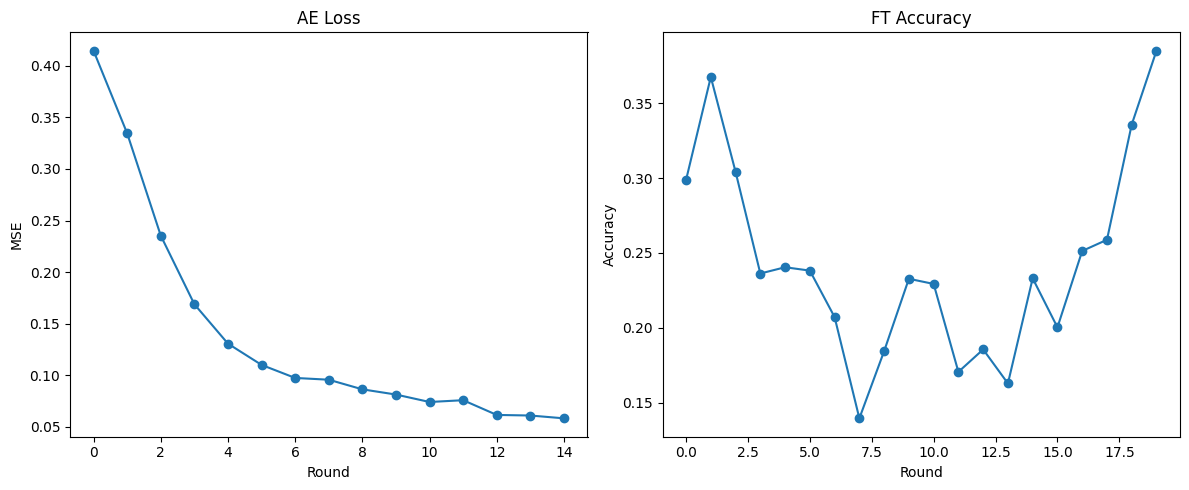

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# ──────────────────────────────────────────────────────────────────────────────
# 1) LOAD & LABEL CSV FILES
# ──────────────────────────────────────────────────────────────────────────────
def read_and_label_csv_files(root_dir):
    dfs = []
    for cls in os.listdir(root_dir):
        p = os.path.join(root_dir, cls)
        if os.path.isdir(p):
            for fn in os.listdir(p):
                if fn.endswith('.csv'):
                    df = pd.read_csv(os.path.join(p, fn))
                    df['label'] = cls
                    dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

root_directory = os.path.expanduser("dataset")
df = read_and_label_csv_files(root_directory)
print("✅ Loaded data:", df.shape)

# ──────────────────────────────────────────────────────────────────────────────
# 2) ENCODE LABELS & SCALE FEATURES
# ──────────────────────────────────────────────────────────────────────────────
le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['label'])
X = df.drop(columns=['label','label_enc']).values.astype(np.float32)
y = df['label_enc'].values

scaler = StandardScaler()
X = scaler.fit_transform(X).astype(np.float32)

# ──────────────────────────────────────────────────────────────────────────────
# 3) TRAIN/TEST SPLIT (80/20)
# ──────────────────────────────────────────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train:", X_train.shape, "Test:", X_test.shape)

# ──────────────────────────────────────────────────────────────────────────────
# 4) NON-IID DIRICHLET SPLIT → 10 CLIENTS
# ──────────────────────────────────────────────────────────────────────────────
def non_iid_dirichlet_split(X, y, num_clients=10, alpha=0.5):
    num_classes = int(y.max())+1
    idx_by_class = [np.where(y==c)[0] for c in range(num_classes)]
    client_idxs = [[] for _ in range(num_clients)]
    for idxs in idx_by_class:
        props = np.random.dirichlet(alpha*np.ones(num_clients))
        counts = (props * len(idxs)).astype(int)
        counts[-1] = len(idxs)-counts[:-1].sum()
        np.random.shuffle(idxs)
        start=0
        for i,cnt in enumerate(counts):
            client_idxs[i].extend(idxs[start:start+cnt])
            start+=cnt
    return [(X[i], y[i]) for i in client_idxs]

train_splits = non_iid_dirichlet_split(X_train, y_train)
for i,(Xi,yi) in enumerate(train_splits,1):
    print(f" Client {i}: X={Xi.shape}, counts={np.bincount(yi)}")

# ──────────────────────────────────────────────────────────────────────────────
# 5) MODEL BUILDERS
# ──────────────────────────────────────────────────────────────────────────────
def build_autoencoder(input_dim):
    inp = Input(shape=(input_dim,))
    x   = layers.Dense(64, activation='relu')(inp)
    x   = layers.Dense(32, activation='relu')(x)
    bott= layers.Dense(16, activation='relu', name='bottleneck')(x)
    x   = layers.Dense(32, activation='relu')(bott)
    x   = layers.Dense(64, activation='relu')(x)
    out = layers.Dense(input_dim, activation='linear')(x)
    return Model(inp, out)

def build_classifier(num_classes):
    inp = Input(shape=(16,))
    x   = layers.Dense(16, activation='relu')(inp)
    out = layers.Dense(num_classes, activation='softmax')(x)
    return Model(inp, out)

# ──────────────────────────────────────────────────────────────────────────────
# 6) FEDERATED TRAIN (MANUAL FedAvg)
# ──────────────────────────────────────────────────────────────────────────────
def federated_train(model_builder, builder_args, client_data, rounds,
                    local_epochs, batch_size, lr, loss_fn, is_classifier=False):
    # 1) init global
    global_model = model_builder(*builder_args)
    global_model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss=loss_fn,
        metrics=['accuracy'] if is_classifier else None
    )
    gw = global_model.get_weights()
    history=[]

    for r in range(1, rounds+1):
        # accumulate deltas
        deltas=[np.zeros_like(w) for w in gw]
        scores=[]
        for Xi, yi in client_data:
            local = model_builder(*builder_args)
            local.set_weights(gw)
            local.compile(
                optimizer=tf.keras.optimizers.Adam(lr),
                loss=loss_fn,
                metrics=['accuracy'] if is_classifier else None
            )
            # prepare ds
            if is_classifier:
                ds=tf.data.Dataset.from_tensor_slices((Xi, yi))
            else:
                ds=tf.data.Dataset.from_tensor_slices((Xi, Xi))
            ds=ds.shuffle(500).batch(batch_size)
            # local train
            local.fit(ds, epochs=local_epochs, verbose=0)
            nw=local.get_weights()
            # collect deltas
            for i in range(len(gw)):
                deltas[i]+=(nw[i]-gw[i])
            # local eval
            if is_classifier:
                preds=local.predict(Xi, batch_size=batch_size, verbose=0)
                scores.append((preds.argmax(1)==yi).mean())
            else:
                scores.append(local.evaluate(ds,verbose=0))
        # server update
        num=len(client_data)
        gw=[w + d/num for w,d in zip(gw, deltas)]
        global_model.set_weights(gw)
        m=np.mean(scores)
        history.append(m)
        tag="Acc" if is_classifier else "Loss"
        print(f"[{'FT' if is_classifier else 'AE'} Round {r:02d}] mean {tag}: {m:.4f}")
    return global_model, history

# ──────────────────────────────────────────────────────────────────────────────
# 7) PRE-TRAIN AUTOENCODER
# ──────────────────────────────────────────────────────────────────────────────
AE_ROUNDS     = 15
AE_EPOCHS     = 2
AE_BATCH      = 256
AE_LR         = 1e-3

ae_clients = [(Xi, Xi) for Xi,_ in train_splits]
ae_model, ae_history = federated_train(
    model_builder=build_autoencoder,
    builder_args=(X_train.shape[1],),
    client_data=ae_clients,
    rounds=AE_ROUNDS,
    local_epochs=AE_EPOCHS,
    batch_size=AE_BATCH,
    lr=AE_LR,
    loss_fn='mse',
    is_classifier=False
)

# ──────────────────────────────────────────────────────────────────────────────
# 8) EXTRACT & FREEZE ENCODER
# ──────────────────────────────────────────────────────────────────────────────
encoder_input = Input(shape=(X_train.shape[1],))
x = ae_model.layers[1](encoder_input)
x = ae_model.layers[2](x)
bott = ae_model.get_layer('bottleneck')(x)
encoder_model = Model(encoder_input, bott)
encoder_model.trainable=False

# ──────────────────────────────────────────────────────────────────────────────
# 9) FINE-TUNE CLASSIFIER
# ──────────────────────────────────────────────────────────────────────────────
FT_ROUNDS     = 20
FT_EPOCHS     = 2
FT_BATCH      = 32
FT_LR         = 1e-3

# prepare classifier clients
ft_clients=[]
for Xi, yi in train_splits:
    emb=encoder_model.predict(Xi, batch_size=AE_BATCH, verbose=0)
    ft_clients.append((emb, yi))

clf_model, ft_history = federated_train(
    model_builder=build_classifier,
    builder_args=(len(le.classes_),),
    client_data=ft_clients,
    rounds=FT_ROUNDS,
    local_epochs=FT_EPOCHS,
    batch_size=FT_BATCH,
    lr=FT_LR,
    loss_fn='sparse_categorical_crossentropy',
    is_classifier=True
)

# ──────────────────────────────────────────────────────────────────────────────
# 10) EVALUATE & PLOT
# ──────────────────────────────────────────────────────────────────────────────
X_test_enc = encoder_model.predict(X_test, batch_size=AE_BATCH, verbose=0)
y_pred_probs = clf_model.predict(X_test_enc, batch_size=FT_BATCH, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred,
                            target_names=le.classes_,
                            zero_division=0))

# plot histories
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(ae_history, marker='o'); plt.title('AE Loss'); plt.xlabel('Round'); plt.ylabel('MSE')
plt.subplot(1,2,2)
plt.plot(ft_history, marker='o'); plt.title('FT Accuracy'); plt.xlabel('Round'); plt.ylabel('Accuracy')
plt.tight_layout(); plt.show()


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ───────────────────────────────────────────────────────────────
# Load Dataset
# ───────────────────────────────────────────────────────────────
def load_data(root_dir):
    dfs = []
    for cls in os.listdir(root_dir):
        cls_path = os.path.join(root_dir, cls)
        if os.path.isdir(cls_path):
            for file in os.listdir(cls_path):
                if file.endswith('.csv'):
                    df = pd.read_csv(os.path.join(cls_path, file))
                    df['label'] = cls
                    dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

df = load_data('dataset')
print(f"✅ Loaded data shape: {df.shape}")

# Encode Labels & Scale Features
le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['label'])
X = df.drop(columns=['label', 'label_enc']).values.astype(np.float32)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = df['label_enc'].values

# ───────────────────────────────────────────────────────────────
# Train-Test Split (Stratified)
# ───────────────────────────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)
print(f"✅ Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# ───────────────────────────────────────────────────────────────
# Apply ADASYN to Entire Train Data (Full balancing)
# ───────────────────────────────────────────────────────────────
print("\n✅ Applying ADASYN to entire train data for class balancing...")
adasyn = ADASYN(random_state=42, n_neighbors=5)
X_train_bal, y_train_bal = adasyn.fit_resample(X_train, y_train)
print(f"✅ Balanced Train shape: {X_train_bal.shape}")

# ───────────────────────────────────────────────────────────────
# Plot Class Distribution After ADASYN
# ───────────────────────────────────────────────────────────────
plt.figure(figsize=(12,5))
sns.barplot(x=le.inverse_transform(np.unique(y_train_bal)),
            y=[np.sum(y_train_bal==i) for i in np.unique(y_train_bal)])
plt.xticks(rotation=45)
plt.title('Train Set Class Distribution After ADASYN Balancing')
plt.show()

# ───────────────────────────────────────────────────────────────
# Now you can continue with your model pipeline (Autoencoder, Classifier etc)
# ───────────────────────────────────────────────────────────────


✅ Loaded data shape: (7160831, 46)
✅ Train shape: (5728664, 45), Test shape: (1432167, 45)

✅ Applying ADASYN to entire train data for class balancing...


In [ ]:
# ────────────────────────────────────────────────────────
# Step 4: Non-IID Dirichlet Split (Federated Clients)
# ────────────────────────────────────────────────────────
def non_iid_dirichlet(X, y, clients=10, alpha=0.5):
    idx_by_class = [np.where(y==c)[0] for c in np.unique(y)]
    client_idxs = [[] for _ in range(clients)]
    for idxs in idx_by_class:
        props = np.random.dirichlet(alpha*np.ones(clients))
        counts = (props * len(idxs)).astype(int)
        counts[-1] = len(idxs) - counts[:-1].sum()
        np.random.shuffle(idxs)
        start = 0
        for i, cnt in enumerate(counts):
            client_idxs[i].extend(idxs[start:start+cnt])
            start += cnt
    return [(X[idx], y[idx]) for idx in client_idxs]

federated_clients = non_iid_dirichlet(X_train_bal, y_train_bal)

# ────────────────────────────────────────────────────────
# Step 5: Autoencoder Model
# ────────────────────────────────────────────────────────
def build_autoencoder(input_dim):
    inp = Input(shape=(input_dim,))
    x = layers.Dense(256, activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(64, activation='relu', name='bottleneck')(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(256, activation='relu')(x)
    out = layers.Dense(input_dim)(x)
    return Model(inp, out)

# ────────────────────────────────────────────────────────
# Step 6: Self-Attention Classifier
# ────────────────────────────────────────────────────────
def build_classifier(num_classes):
    inp = Input(shape=(64,))
    attention = layers.Dense(64, activation='tanh')(inp)
    attention_scores = layers.Dense(64, activation='softmax')(attention)
    context_vector = layers.multiply([inp, attention_scores])
    x = layers.Dense(64, activation='relu')(context_vector)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    return Model(inp, out)

# ────────────────────────────────────────────────────────
# Step 7: Federated Training Function
# ────────────────────────────────────────────────────────
def federated_train(model_fn, args, clients, rounds, local_epochs, batch, lr, loss, classify=False):
    global_model = model_fn(*args)
    global_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss=loss,
                         metrics=['accuracy'] if classify else None)
    global_weights = global_model.get_weights()

    for r in range(rounds):
        local_weights, local_scores = [], []
        for Xc, yc in clients:
            model = model_fn(*args)
            model.set_weights(global_weights)
            model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss=loss,
                          metrics=['accuracy'] if classify else None)
            target = yc if classify else Xc
            model.fit(Xc, target, epochs=local_epochs, batch_size=batch, verbose=0)
            score = model.evaluate(Xc, yc if classify else Xc, verbose=0)[1 if classify else 0]
            local_scores.append(score)
            local_weights.append(model.get_weights())
        global_weights = np.mean(local_weights, axis=0)
        global_model.set_weights(global_weights)
        metric = "Accuracy" if classify else "Loss"
        print(f"[Round {r+1}/{rounds}] Avg {metric}: {np.mean(local_scores):.4f}")
    return global_model

# ────────────────────────────────────────────────────────
# Step 8: Federated Autoencoder Training
# ────────────────────────────────────────────────────────
ae_model = federated_train(
    build_autoencoder, (X_train_bal.shape[1],), federated_clients,
    rounds=10, local_epochs=1, batch=128, lr=0.001, loss='mse', classify=False
)

encoder = Model(ae_model.input, ae_model.get_layer('bottleneck').output)
encoder.trainable = False

# ────────────────────────────────────────────────────────
# Step 9: Federated Classifier Training
# ────────────────────────────────────────────────────────
clf_clients = [(encoder.predict(X), y) for X, y in federated_clients]

classifier = federated_train(
    build_classifier, (len(np.unique(y_train_bal)),), clf_clients,
    rounds=15, local_epochs=1, batch=64, lr=0.001, loss='sparse_categorical_crossentropy', classify=True
)

# ────────────────────────────────────────────────────────
# Step 10: Final Evaluation
# ────────────────────────────────────────────────────────
X_test_enc = encoder.predict(X_test)
y_pred = classifier.predict(X_test_enc).argmax(axis=1)

print("\n✅ Final Classification Report:")
target_names = le.inverse_transform(np.unique(y_train_bal))
print(classification_report(y_test, y_pred, target_names=target_names))